<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install -q -U keras-tuner

In [48]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_tuner as kt
print("Done importing packages!")

Done importing packages!


In [49]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [50]:
data_dir = "PlanDoc_augmented"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.1,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)


validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.1,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)


test_dataset = image_dataset_from_directory('testplantdoc',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset_indoor = image_dataset_from_directory('plantville_test',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 17312 files belonging to 13 classes.
Using 15581 files for training.
Found 17312 files belonging to 13 classes.
Using 1731 files for validation.
Found 120 files belonging to 13 classes.
Found 4026 files belonging to 13 classes.


In [51]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper__bell___Bacterial_spot
5.  Pepper__bell___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


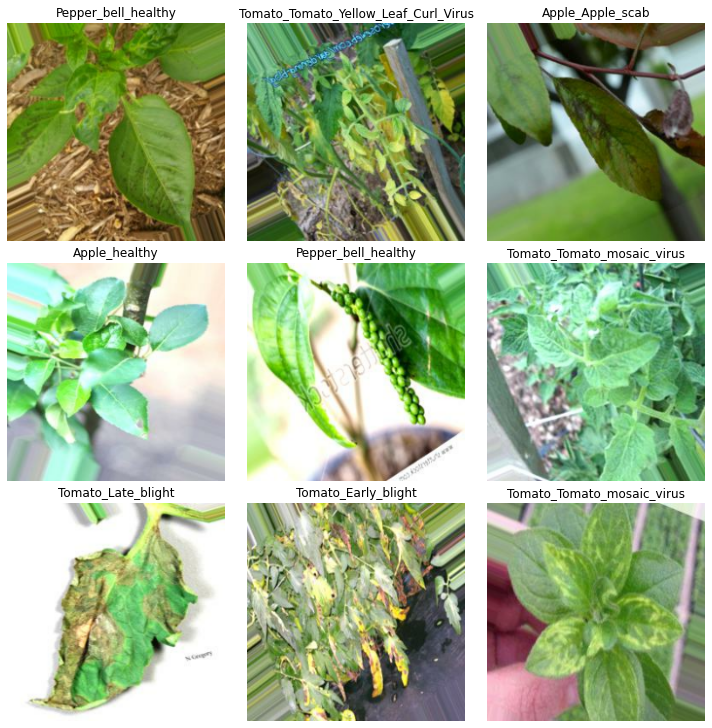

In [52]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

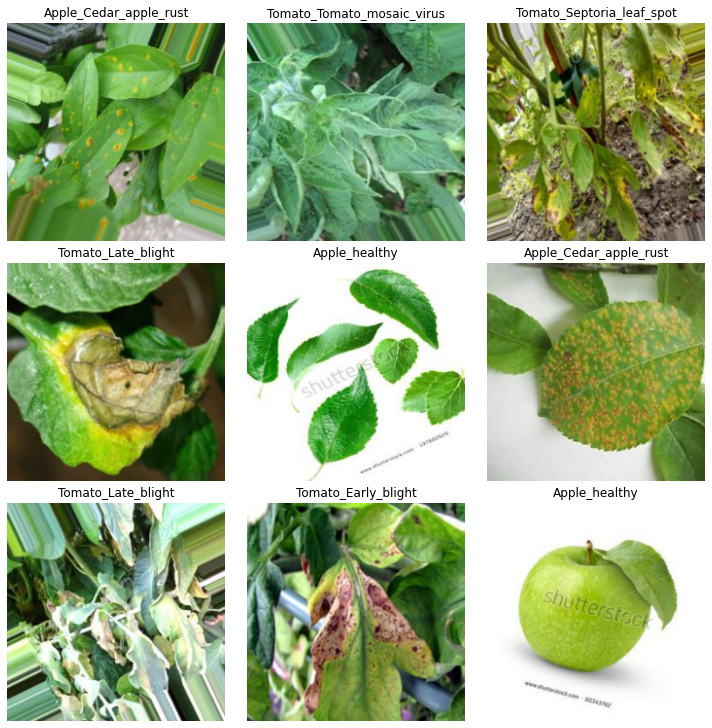

In [53]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [54]:
#val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of indoor test batches: %d' % tf.data.experimental.cardinality(test_dataset_indoor))

Number of validation batches: 55
Number of test batches: 4
Number of indoor test batches: 126


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_indoor = test_dataset_indoor.prefetch(buffer_size=AUTOTUNE)

In [56]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [57]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [58]:
IMG_SHAPE = IMG_SIZE + (3,)

In [59]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [60]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


In [61]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [62]:
base_model.trainable = False

In [63]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [64]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [65]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = train_dataset(inputs)
x = preprocess_input(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [66]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")


In [67]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [68]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [69]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [70]:
len(model.trainable_variables)

2

In [71]:
initial_epochs = 10

In [72]:
len(train_dataset)

487

In [73]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
487/487 [==============================] - 54s 102ms/step - loss: 2.8336 - tp: 34.0000 - fp: 208.0000 - tn: 186764.0000 - fn: 15547.0000 - accuracy: 0.0992 - precision: 0.1405 - recall: 0.0022 - auc: 0.5397 - val_loss: 2.6457 - val_tp: 2.0000 - val_fp: 6.0000 - val_tn: 20766.0000 - val_fn: 1729.0000 - val_accuracy: 0.1144 - val_precision: 0.2500 - val_recall: 0.0012 - val_auc: 0.5785
Epoch 2/10
487/487 [==============================] - 48s 98ms/step - loss: 2.5916 - tp: 56.0000 - fp: 156.0000 - tn: 186816.0000 - fn: 15525.0000 - accuracy: 0.1358 - precision: 0.2642 - recall: 0.0036 - auc: 0.6092 - val_loss: 2.4714 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 20767.0000 - val_fn: 1722.0000 - val_accuracy: 0.1548 - val_precision: 0.6429 - val_recall: 0.0052 - val_auc: 0.6478
Epoch 3/10
487/487 [==============================] - 50s 102ms/step - loss: 2.4419 - tp: 111.0000 - fp: 158.0000 - tn: 186814.0000 - fn: 15470.0000 - accuracy: 0.1760 - precision: 0.4126 - recall: 0.0071 

In [74]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 1s 86ms/step - loss: 2.7032 - tp: 2.0000 - fp: 7.0000 - tn: 1433.0000 - fn: 118.0000 - accuracy: 0.0917 - precision: 0.2222 - recall: 0.0167 - auc: 0.6129    


In [75]:
result = model.evaluate(test_dataset_indoor)

126/126 [==============================] - 11s 88ms/step - loss: 2.7125 - tp: 23.0000 - fp: 64.0000 - tn: 48248.0000 - fn: 4003.0000 - accuracy: 0.1627 - precision: 0.2644 - recall: 0.0057 - auc: 0.5792


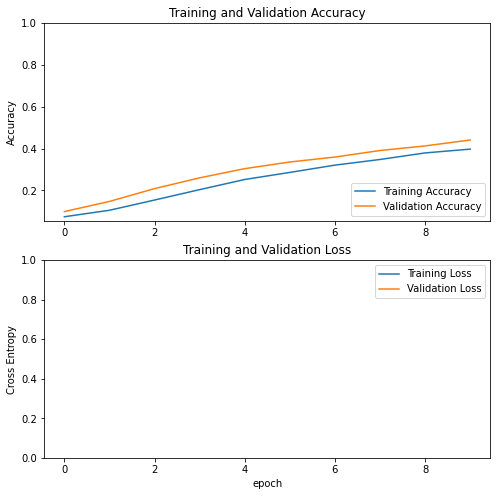

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

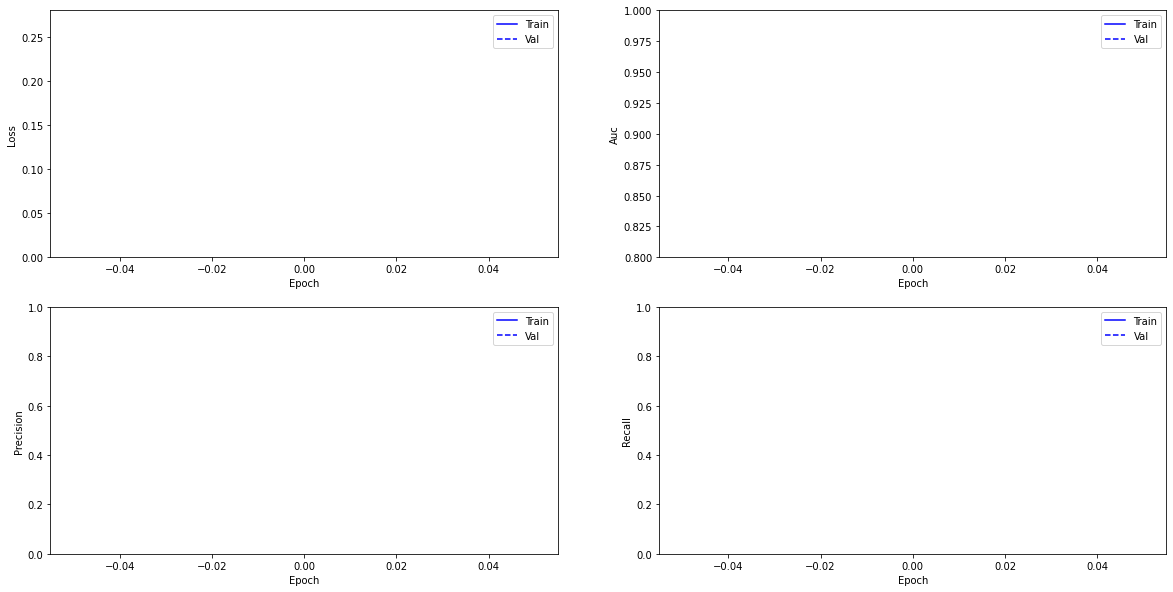

In [ ]:
plot_metrics(history)

In [33]:
base_model.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [35]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [37]:
len(model.trainable_variables)

56

In [38]:

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
487/487 [==============================] - 77s 144ms/step - loss: 1.2768 - tp: 6081.0000 - fp: 1705.0000 - tn: 206039.0000 - fn: 11231.0000 - accuracy: 0.5576 - precision: 0.7810 - recall: 0.3513 - auc: 0.9232 - val_loss: 0.9005 - val_tp: 915.0000 - val_fp: 138.0000 - val_tn: 20634.0000 - val_fn: 816.0000 - val_accuracy: 0.7054 - val_precision: 0.8689 - val_recall: 0.5286 - val_auc: 0.9677
Epoch 11/20
487/487 [==============================] - 68s 140ms/step - loss: 0.7400 - tp: 9959.0000 - fp: 1564.0000 - tn: 185408.0000 - fn: 5622.0000 - accuracy: 0.7541 - precision: 0.8643 - recall: 0.6392 - auc: 0.9776 - val_loss: 0.6132 - val_tp: 1211.0000 - val_fp: 140.0000 - val_tn: 20632.0000 - val_fn: 520.0000 - val_accuracy: 0.8111 - val_precision: 0.8964 - val_recall: 0.6996 - val_auc: 0.9850
Epoch 12/20
487/487 [==============================] - 68s 140ms/step - loss: 0.4776 - tp: 12124.0000 - fp: 1090.0000 - tn: 185882.0000 - fn: 3457.0000 - accuracy: 0.8527 - precision: 0.9175

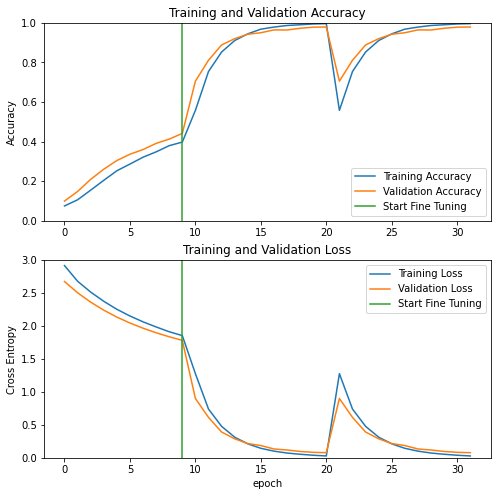

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

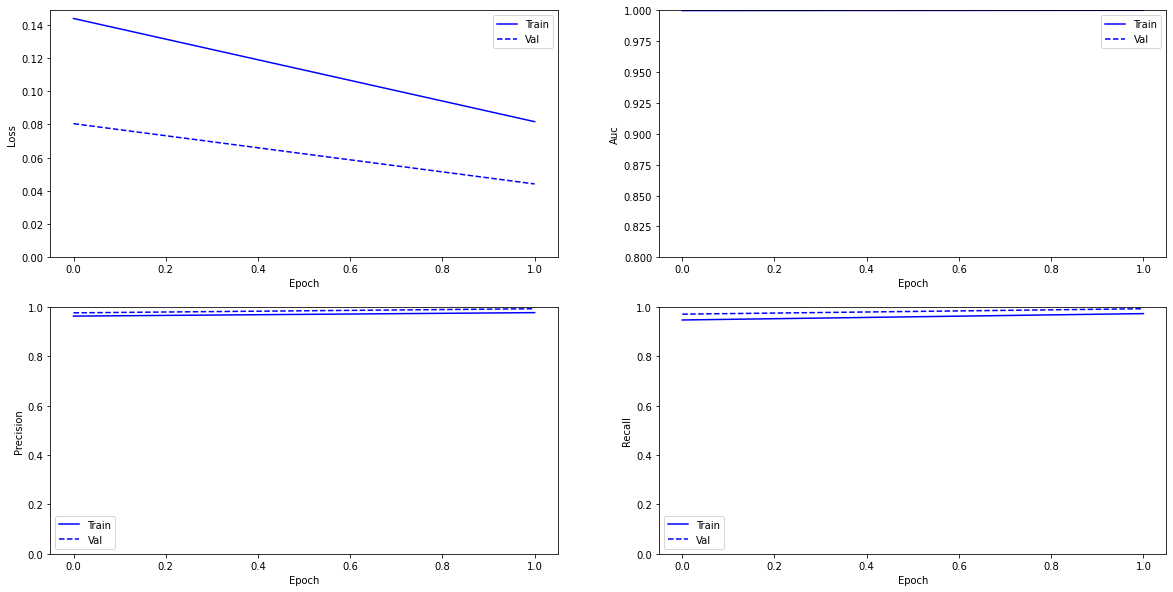

In [ ]:
plot_metrics(history_fine)

In [41]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 2s 202ms/step - loss: 6.4888 - tp: 14.0000 - fp: 93.0000 - tn: 1347.0000 - fn: 106.0000 - accuracy: 0.1250 - precision: 0.1308 - recall: 0.1167 - auc: 0.5876


In [44]:
result = model.evaluate(test_dataset_indoor)

126/126 [==============================] - 11s 86ms/step - loss: 4.3333 - tp: 821.0000 - fp: 2552.0000 - tn: 45760.0000 - fn: 3205.0000 - accuracy: 0.2235 - precision: 0.2434 - recall: 0.2039 - auc: 0.6746


In [45]:
result = model.evaluate(validation_dataset)

55/55 [==============================] - 5s 86ms/step - loss: 0.0776 - tp: 1688.0000 - fp: 32.0000 - tn: 20740.0000 - fn: 43.0000 - accuracy: 0.9792 - precision: 0.9814 - recall: 0.9752 - auc: 0.9998


In [ ]:
print(len(test_dataset))

2


In [ ]:
print(len(validation_dataset))

12


In [ ]:
print(len(train_dataset))

54


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.031
tp : 63.0
fp : 1.0
tn : 2367.0
fn : 1.0
accuracy : 0.984
precision : 0.984
recall : 0.984
auc : 1.0


Predictions:
 [35, 19, 35, 35, 17, 17, 35, 35, 19, 35, 17, 17, 18, 17, 35, 18, 35, 35, 35, 35, 19, 35, 18, 35, 19, 35, 18, 35, 35, 35, 19, 35]
Labels:
 [35, 19, 35, 35, 17, 17, 35, 35, 19, 35, 17, 19, 18, 17, 35, 18, 35, 35, 35, 35, 19, 35, 18, 35, 19, 35, 19, 35, 35, 35, 19, 35]


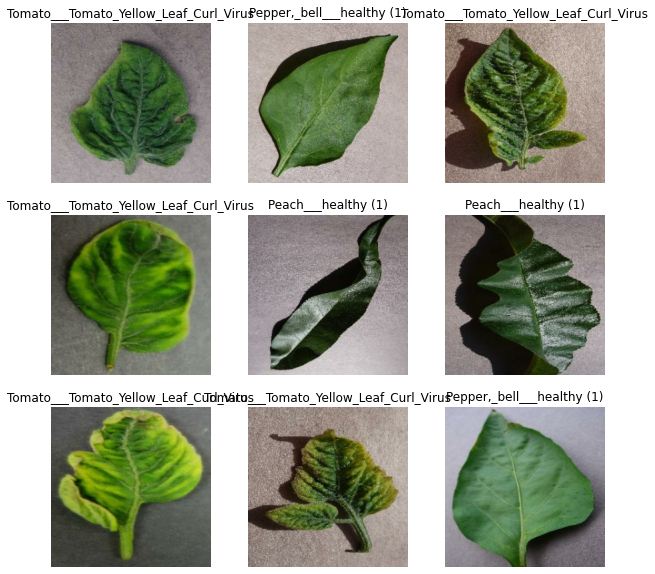

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./inception_v3")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
